수정한점: \
교수님이 주신 CNN모델을 활용하여 두개의 CNN모델을 add하고 첫날 최고 점수를 냈던 모델과 concatenate를 하였습니다.\
 그래서 3개의 input과 하나의 out으로 이루어진 최종 모델을 만들어 학습하였습니다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
from google.colab import files
uploaded = files.upload()

Saving X_data_drop.csv to X_data_drop.csv


In [0]:
X_df = pd.read_csv("X_data_drop.csv")
y_train = pd.read_csv("y_train.csv")

In [0]:
data=pd.merge(X_df,y_train,on='cust_id',how='outer')
object=['season_prefer','휴면여부','기타_구매여부','농산물_구매여부','가공식품_구매여부','시즌선호도','최고가상품',
       '축산가공_구매여부','수산품_구매여부','화장품_구매여부','디자이너_구매여부','주구매지역',
       '시티웨어_구매여부','일용잡화_구매여부','육류_구매여부','주구매상품','주구매지점',
       '가장 처음 산것','가장 마지막으로 산 것','주요방문일자','가장 많이 방문한 월',
       'vip','childs','vip_amount','day','vip_class','purchase_count',
       'max_amount_range1','max_amount_range2','total_amount_avg_range1','total_amount_avg_range2',
       'total_amount_avg_range3']
for o in object:
    data[o]=data.loc[:,o].map(data.groupby(o)['gender'].agg(np.mean))

In [0]:
X_df = data.drop(columns="gender")

In [0]:
X_df = X_df.fillna(0.5)

# 이상치(outlier)를 제거한다.
X_df.iloc[:,1:] = X_df.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

In [0]:
x_train = X_df.iloc[:3500,1:]
x_test = X_df.iloc[3500:,1:]
y_train = pd.read_csv("y_train.csv")
y_train = y_train["gender"]

In [0]:
#MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [10]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import sequence
from keras.preprocessing.text import *
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [0]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender

In [13]:
max_features = 100000
max_len = 1000
emb_dim = 128

#y_train=y_train.gender
# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X1_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X1_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

X2_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X2_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

for i in range(X1_train.shape[0]):
    x1 = np.unique(X1_train[i])
    y1 = np.array([])
    for j in range(5):
        y1 = np.append(y1, np.random.choice(x1, len(x1), replace=False))
    X1_train[i] = y1    
#    X_train[i] = np.random.choice(x, len(x), replace=False)

for i in range(X1_test.shape[0]):
    x1 = np.unique(X1_test[i])
    y1 = np.array([])
    for j in range(5):
        y1 = np.append(y1, np.random.choice(x1, len(x1), replace=False))
    X1_test[i] = y1    
#    X_test[i] = np.random.choice(x, len(x)*5)    
    
# Pads sequences to the same length
X1_train = sequence.pad_sequences(X1_train, maxlen=max_len)
X1_test = sequence.pad_sequences(X1_test, maxlen=max_len)


for i in range(X2_train.shape[0]):
    x2 = np.unique(X2_train[i])
    y2 = np.array([])
    for j in range(5):
        y2 = np.append(y2, np.random.choice(x2, len(x2), replace=False))
    X2_train[i] = y2    
#    X_train[i] = np.random.choice(x, len(x), replace=False)

for i in range(X2_test.shape[0]):
    x2 = np.unique(X2_test[i])
    y2 = np.array([])
    for j in range(5):
        y2 = np.append(y2, np.random.choice(x2, len(x2), replace=False))
    X2_test[i] = y2    
#    X_test[i] = np.random.choice(x, len(x)*5)    
    
# Pads sequences to the same length
X2_train = sequence.pad_sequences(X2_train, maxlen=max_len)
X2_test = sequence.pad_sequences(X2_test, maxlen=max_len)

X2_train.shape, X2_test.shape

((3500, 1000), (2482, 1000))

In [0]:
from keras.models import Model
from keras import Input
from keras import layers
from keras.optimizers import RMSprop
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate

  0%|          | 0/10 [00:00<?, ?it/s]

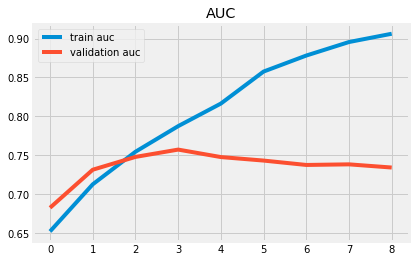

AUC 0.7537112299465241


 10%|█         | 1/10 [03:55<35:16, 235.14s/it]

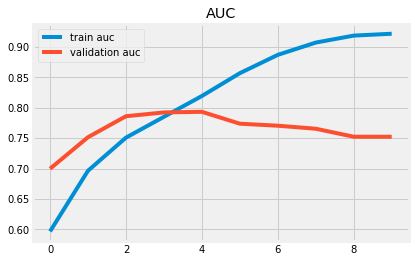

AUC 0.7878064579100081


 20%|██        | 2/10 [08:06<32:00, 240.11s/it]

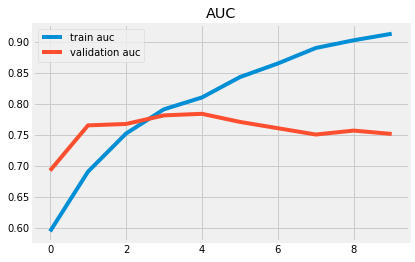

AUC 0.7818335504015043


 30%|███       | 3/10 [12:19<28:26, 243.79s/it]

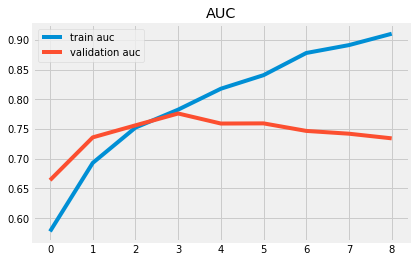

AUC 0.7669055944055945


 40%|████      | 4/10 [16:03<23:47, 237.93s/it]

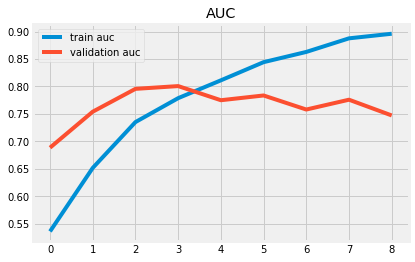

AUC 0.7938213220931428


 50%|█████     | 5/10 [19:43<19:22, 232.56s/it]

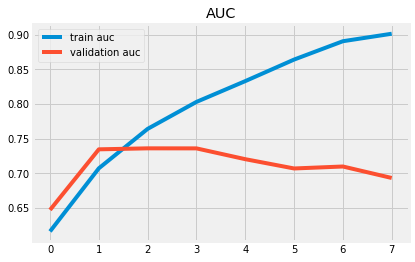

AUC 0.7337906597194949


 60%|██████    | 6/10 [23:07<14:55, 223.96s/it]

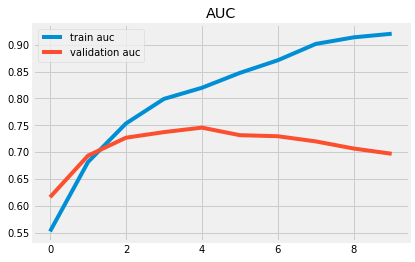

AUC 0.7439234065579208


 70%|███████   | 7/10 [27:12<11:30, 230.31s/it]

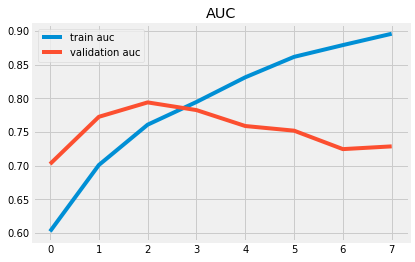

AUC 0.7930461318149271


 80%|████████  | 8/10 [30:32<07:22, 221.16s/it]

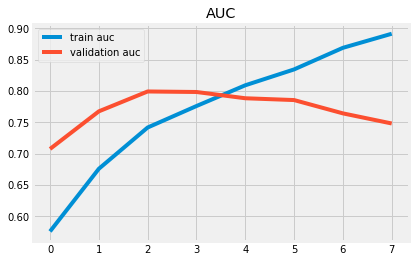

AUC 0.7948248869052252


 90%|█████████ | 9/10 [33:47<03:33, 213.30s/it]

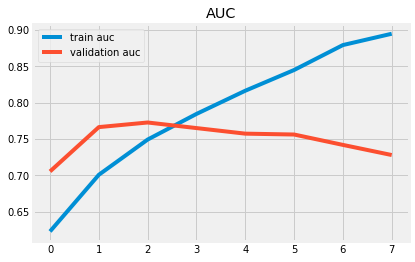

AUC 0.7722902097902098


100%|██████████| 10/10 [37:07<00:00, 222.75s/it]


Validation Summary:
8    0.794825
4    0.793821
7    0.793046
1    0.787806
2    0.781834
9    0.772290
3    0.766906
0    0.753711
6    0.743923
5    0.733791
dtype: float64
mean=0.77220, std=0.022


In [16]:
from tqdm import tqdm
import random
#현재 베스트
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    gds_input = Input(shape=(max_len,), dtype='int32', name='gds_nm')
    gds_emb = layers.Embedding(max_features, emb_dim)(gds_input)
    gds_enc1 = layers.Conv1D(32, 1, activation='relu',padding='same')(gds_emb)
    gds_enc1 = layers.Conv1D(32, 1, activation='relu',padding='same')(gds_enc1)

    mcla_input = Input(shape=(max_len,), dtype='int32', name='gds_mclas_nm')
    mcla_emb = layers.Embedding(max_features, emb_dim)(mcla_input)
    mcla_enc1 = layers.Conv1D(32, 1, activation='relu',padding='same')(mcla_emb)
    mcla_enc1 = layers.Conv1D(32, 1, activation='relu',padding='same')(mcla_enc1)

    nm_add = layers.add([gds_enc1,mcla_enc1])
    flatten1 = layers.Flatten()(nm_add)
    dropout1 = layers.Dropout(0.5)(flatten1)
    nm_out = layers.Dense(64,activation='relu',)(dropout1)
    nm_model = Model([gds_input,mcla_input],nm_out)

    yg_input = Input(shape=(x_train.shape[1],),name='yoongyung')
    yg_dnn1 = layers.Dense(64,activation='relu',kernel_regularizer=l2(0.005))(yg_input)
    yg_dropout1 = layers.Dropout(0.2)(yg_dnn1)
    yg_dnn2 = layers.Dense(32, activation='relu')(yg_dropout1)
    yg_dropout2 = layers.Dropout(0.2)(yg_dnn2)
    yg_model = Model(yg_input,yg_dropout2)

    concatenated = concatenate([nm_out, yg_dropout2])
    dense1 = layers.Dense(64,activation='relu')(concatenated)
    dropout1 = layers.Dropout(0.2)(dense1)
    dense2 = layers.Dense(128,activation='relu')(dropout1)
    dense3 = layers.Dense(64,activation='relu')(dense2)
    gender = layers.Dense(1,activation='sigmoid')(dense3)

    Fin_model = Model([gds_input,mcla_input,yg_input],gender)

    Fin_model.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=[auroc])

    filepath="/content/gdrive/My Drive/best_fin_model" +str(i)+".tf"

    mc = ModelCheckpoint(filepath, monitor='val_auroc', mode='max', save_best_only=True)
    es = EarlyStopping(monitor='val_auroc',patience=5, mode='max')
    #rp = ReduceLROnPlateau(monitor = 'val_auroc', factor = 0.5, patience = 2,mode='max')

    train_x1, valid_x1, train_y, valid_y = train_test_split(X1_train, y_train, test_size=0.2,random_state=SEED)
    train_x2, valid_x2, train_y, valid_y = train_test_split(X2_train, y_train, test_size=0.2,random_state=SEED)
    train_x3, valid_x3, train_y, valid_y = train_test_split(x_train, y_train, test_size=0.2,random_state=SEED)

    history = Fin_model.fit([train_x1,train_x2,train_x3], train_y, epochs=100, batch_size=64, 
                        validation_data=([valid_x1,valid_x2,valid_x3],valid_y), callbacks=[mc,es],verbose=0)

    plt.plot(history.history["auroc"], label="train auc")
    plt.plot(history.history["val_auroc"], label="validation auc")
    plt.legend()
    plt.title("AUC")
    plt.show()

    from keras.models import load_model
    dependencies = {
        'auroc': auroc
    }

    nowbest_model = load_model(filepath, custom_objects=dependencies)

    auc = roc_auc_score(valid_y, nowbest_model.predict([valid_x1,valid_x2,valid_x3]))
    aucs.append(auc)
    print('AUC', auc)
    preds.append(nowbest_model.predict([X1_test,X2_test,x_test]))  

print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))



In [0]:
# Power mean ensemble
THRESHOLD = 0.79  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

In [0]:
pr=[]
for i in pred.tolist():
  j=i[0]
  pr.append(j)

In [0]:
# Make a submission file
from datetime import date
from google.colab import files
today=date.today()

mydf=pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pr}).to_csv('홍재성2_06'+str(today.day)+'_0936.csv', index=False, encoding='cp949')
files.download('홍재성2_06'+str(today.day)+'_0936.csv')